# 22차시: 모델 성능 평가 (MSE, R-squared, Confusion Matrix)

## 학습 목표
- 회귀 모델 평가 지표 (MSE, RMSE, R2)의 **의미** 이해
- 분류 모델 평가 지표 (Accuracy, Precision, Recall)의 **차이** 이해
- **금융 상황에 맞는 지표 선택** 방법 학습

## 학습 내용
1. 왜 평가 지표가 중요한가?
2. 회귀 평가 지표: R2와 RMSE
3. 분류 평가 지표: Precision vs Recall
4. Confusion Matrix 이해
5. 금융에서의 지표 선택

## 중요 주의사항 (Warning)

본 교재와 실습에서 사용하는 모든 데이터, 모델, 기법은
오직 머신러닝 개념 이해와 교육 목적을 위한 예제입니다. 따라서,
실제 금융 시장의 복잡성, 리스크, 거래 비용, 정책·심리 요인 등을 전혀 반영하지 못하며, 실제 투자 판단이나 매매 전략에 사용해서는 안 됩니다.

실습 결과는 "참고용·학습용"으로만 활용하시기 바랍니다.

In [1]:
!pip install -Uq finance-datareader koreanize-matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from datetime import datetime, timedelta
from IPython.display import display

---
## 1. 왜 평가 지표가 중요한가?

### 모델이 "좋다"는 것을 어떻게 판단할까?

- 20차시에서 만든 회귀 모델의 R2가 0.85라면 좋은 건가요?
- 21차시에서 만든 분류 모델의 Accuracy가 60%라면 좋은 건가요?

### 평가 지표 선택이 중요한 이유

| 상황 | 잘못된 선택 | 결과 |
|------|-------------|------|
| 불균형 데이터 | Accuracy만 봄 | 성능 과대평가 |
| 매수 신호 예측 | Recall만 봄 | 잘못된 매수 증가 |
| 부도 예측 | Precision만 봄 | 실제 부도 놓침 |

**결론: 상황에 맞는 지표 선택이 필수!**

---
## 2. 회귀 모델의 평가 지표: R2와 RMSE

20차시에서 배운 회귀 모델을 복습하며 지표의 **의미**를 깊이 이해합니다.

### 주요 지표
| 지표 | 의미 | 해석 |
|------|------|------|
| R2 | 모델이 데이터를 얼마나 잘 설명하는가 | 0~1, 높을수록 좋음 |
| RMSE | 평균적으로 얼마나 틀리는가 | 원래 단위(원), 낮을수록 좋음 |

In [3]:
import FinanceDataReader as fdr
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 삼성전자 데이터 수집
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

print("[데이터 수집 - 삼성전자]")
df = fdr.DataReader("005930", start_date, end_date)

# 특성 생성
df['전일종가'] = df['Close'].shift(1)
df['수익률'] = df['Close'].pct_change() * 100
df['5일이동평균'] = df['Close'].rolling(5).mean()
df['거래량비율'] = df['Volume'] / df['Volume'].rolling(20).mean()
df['다음날종가'] = df['Close'].shift(-1)
df = df.dropna()
df.head()

[데이터 수집 - 삼성전자]


,Open,High,Low,Close,Volume,Change,전일종가,수익률,5일이동평균,거래량비율,다음날종가
Date,,,,,,,,,,,
2025-02-12,55100,55900,54500,55800,26428596,0.001795,55700.0,0.179533,54960.0,1.305524,55800.0
2025-02-13,56100,56400,55600,55800,22448377,0.000000,55800.0,0.000000,55320.0,1.091681,56000.0
2025-02-14,56000,57300,56000,56000,23979779,0.003584,55800.0,0.358423,55780.0,1.146333,56000.0
2025-02-17,56100,56500,55700,56000,11916027,0.000000,56000.0,0.000000,55860.0,0.577293,56900.0
2025-02-18,56200,57200,55900,56900,22131007,0.016071,56000.0,1.607143,56100.0,1.063148,58700.0


In [4]:
# 회귀 모델 학습
feature_cols = ['전일종가', '수익률', '5일이동평균', '거래량비율']
X = df[feature_cols]
y = df['다음날종가']

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_reg = LinearRegression()
model_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [5]:
# 다음날 종가 예측
y_pred_reg = model_reg.predict(X_test_scaled)
y_pred_reg

array([108252.22196459, 105589.30502051, 103264.02383857, 101433.8591978 ,
       101925.81303983, 103786.46191787, 103783.10628767, 103937.04921407,
       101049.32916167, 101926.84357629, 100448.43077575,  98900.16453745,
       101061.71438784,  98172.76710856,  98470.27348131,  99586.61211573,
       102404.18506756, 103209.36882633, 102251.60249056, 102137.78042091,
       104004.78108503, 105122.56755259, 105572.96886661, 108380.611942  ,
       109848.50110658, 109818.69950953, 109659.15098764, 110093.71284841,
       110269.1161534 , 108577.62515627, 106368.05300403, 108863.00737187,
       109320.32876272, 108772.72202735, 111036.03749197, 112525.89114038,
       112280.51834765, 117011.95036641, 119280.03568041, 120662.78982005,
       126389.69081611, 134730.47162411, 138972.69347439, 141601.64910218,
       142521.31187699])

In [6]:
# 회귀 평가 지표 계산
r2 = r2_score(y_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg))

print("[회귀 모델 평가 지표]")
print("=" * 50)
print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:,.0f}원")

[회귀 모델 평가 지표]
R2 Score: 0.9078
RMSE: 3,804원


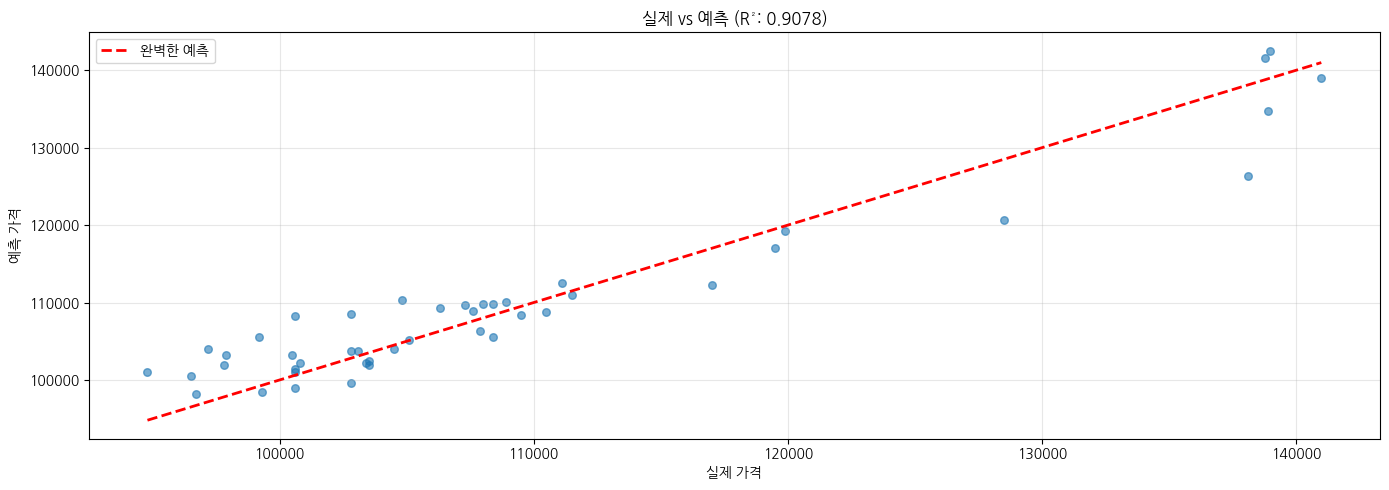


RMSE 3,804원의 의미:
→ 평균적으로 실제 주가와 3,804원 정도 차이남
→ 현재 주가 138,800원 대비 약 2.7% 오차


In [7]:
# 회귀 모델 시각화 (단일 그래프)
plt.figure(figsize=(14, 5))

# 실제값 vs 예측값 산점도
plt.scatter(y_test, y_pred_reg, alpha=0.6, s=30)

# 완벽한 예측선 (y = x)
plt.plot(
    [y_test.min(), y_test.max()],  [y_test.min(), y_test.max()],
    'r--',  linewidth=2, label='완벽한 예측'
)

# 그래프 설정
plt.xlabel('실제 가격')
plt.ylabel('예측 가격')
plt.title(f'실제 vs 예측 (R²: {r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRMSE {rmse:,.0f}원의 의미:")
print(f"→ 평균적으로 실제 주가와 {rmse:,.0f}원 정도 차이남")
print(f"→ 현재 주가 {df['Close'].iloc[-1]:,}원 대비 약 {rmse/df['Close'].iloc[-1]*100:.1f}% 오차")

---
## 3. 분류 모델의 평가 지표: Precision vs Recall

21차시에서 배운 분류 모델을 복습하며 **Precision과 Recall의 차이**를 이해합니다.

### 핵심 개념
| 지표 | 질문 | 수식 |
|------|------|------|
| **Accuracy** | 전체 중 맞춘 비율은? | (TP + TN) / 전체 |
| **Precision** | 상승 예측 중 실제로 상승한 비율은? | TP / (TP + FP) |
| **Recall** | 실제 상승 중 예측한 비율은? | TP / (TP + FN) |

### 용어 정리
- **TP (True Positive)**: 상승 예측 → 실제 상승 (정답!)
- **FP (False Positive)**: 상승 예측 → 실제 하락 (잘못된 매수 신호)
- **FN (False Negative)**: 하락 예측 → 실제 상승 (기회 놓침)
- **TN (True Negative)**: 하락 예측 → 실제 하락 (정답!)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 분류 모델용 타겟 생성 (21차시와 동일)
df_cls = df.copy()
df_cls['다음날상승'] = (df_cls['다음날종가'] > df_cls['Close']).astype(int)

X_cls = df_cls[feature_cols]
y_cls = df_cls['다음날상승']

X_train_cls, X_test_cls = X_cls[:split_idx], X_cls[split_idx:]
y_train_cls, y_test_cls = y_cls[:split_idx], y_cls[split_idx:]

X_train_cls_scaled = scaler.fit_transform(X_train_cls)
X_test_cls_scaled = scaler.transform(X_test_cls)

model_cls = LogisticRegression(random_state=42, max_iter=1000)
model_cls.fit(X_train_cls_scaled, y_train_cls)

LogisticRegression(max_iter=1000, random_state=42)

In [9]:
# 주가 상승, 하락 예측
y_pred_cls = model_cls.predict(X_test_cls_scaled)
y_pred_cls

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [10]:
# 실제 상승, 하락
y_test_cls.value_counts()

,count
다음날상승,
1,26
0,19


---
## 4. Confusion Matrix 이해

Confusion Matrix에서 각 지표가 어떻게 계산되는지 직접 확인합니다.

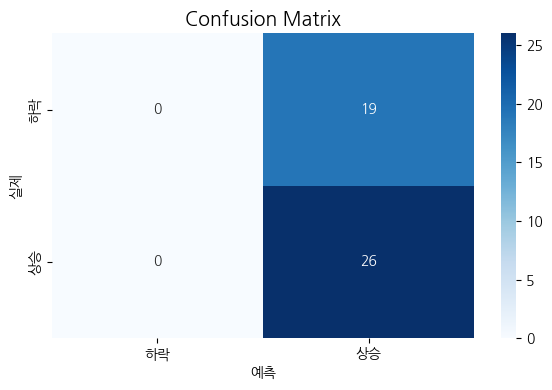

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix 계산
cm = confusion_matrix(y_test_cls, y_pred_cls)

# Confusion Matrix 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['하락', '상승'], yticklabels=['하락', '상승'])
plt.xlabel('예측')
plt.ylabel('실제')
plt.title('Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

---
## 5. 금융에서의 지표 선택

### 상황별 중요 지표

| 상황 | 중요 지표 | 이유 |
|------|-----------|------|
| **매수 신호 예측** | Precision | FP(잘못된 매수)가 비용 발생 |
| **부도 예측** | Recall | FN(부도 놓침)이 큰 손실 |
| **전반적 성능** | Accuracy | 데이터가 균형일 때만 |

---
## 학습 정리

### 1. 회귀 평가 지표
| 지표 | 의미 | 좋은 값 |
|------|------|---------|
| R2 | 설명력 | 1에 가까울수록 |
| RMSE | 평균 오차 | 작을수록 |

### 2. 분류 평가 지표
| 지표 | 의미 | 언제 중요? |
|------|------|-----------|
| Accuracy | 전체 정확도 | 균형 데이터 |
| Precision | 예측 신뢰도 | 잘못된 매수 방지 |
| Recall | 포착률 | 기회 놓치지 않기 |
---

### 다음 차시 예고
- 23차시: 딥러닝 기초 - LSTM 이해하기
  - RNN과 LSTM의 원리
  - 시계열 예측에 특화된 구조
  - TensorFlow/Keras 기초